# Recommender Systems 2020/21



## Practice 2 - Non personalized recommenders

Today, we will be building **non-personalized** recommenders from scratch.


## Outline

* Sparse Matrices Recap
* Evaluation Metrics
 * Precision
 * Recall
 * Mean Average Precision
* Recommenders
 * Random 
 * Top Popular
 * Global Bias
* Extra: Dataset management

In [1]:
from typing import Tuple
from urllib.request import urlretrieve
import matplotlib.pyplot as pyplot
import os
import numpy as np
import scipy.sparse as sps
import zipfile

## We will use the Movielens 10 million dataset.

All the processing to download, read, process and analyze the data is detailed at the end of the notebook 🤓

For now, we will read the arrays that we export there. Here's how the data looks like for the first rows:

| user_id | item_id | rating | timestamp |
|---------|---------|--------|-----------|
| 1       | 122     | 5      | 838985046 |
| 1       | 185     | 5      | 838983525 |
| 1       | 231     | 5      | 838983392 |
| 1       | 292     | 5      | 838983421 |
| 1       | 316     | 5      | 838983392 |
| 1       | 329     | 5      | 838983392 |

Imagine this but with approximately 10 million records 😅

In [2]:
data_path = os.path.join(".", "data", "Movielens_10M", "ml10m-processed.npz")
with np.load(data_path) as ml10m_data:
    user_ids = ml10m_data["user_ids"]
    item_ids = ml10m_data["item_ids"]
    ratings = ml10m_data["ratings"]
    timestamps = ml10m_data["timestamps"]
    
user_ids[:6], item_ids[:6], ratings[:6], timestamps[:6]

(array([1, 1, 1, 1, 1, 1]),
 array([122, 185, 231, 292, 316, 329]),
 array([5., 5., 5., 5., 5., 5.]),
 array([838985046, 838983525, 838983392, 838983421, 838983392, 838983392]))

## Time to shine Sparse Matrices!

To store the data we use a sparse matrix. We build it as a `COO` matrix and then change its format to a faster one (either `CSC` or `CSR`). The `COO` constructor expects `(data, (row, column))`

In [3]:
URM_all = sps.coo_matrix((ratings, (user_ids, item_ids)))
URM_all

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

In [4]:
URM_all.tocsr()

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

## Before building recommenders

We need a consistent and valid way to evaluate our recommenders. For that we're going to define:
* A splitting of the data in `URM_train` and `URM_test`
* An evaluation metric
* A function computing the evaluation for each user

## ⚠️⚠️⚠️Ultra Mega Super Important⚠️⚠️⚠️

### Data splitting is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen.

If you're not careful, then your model can become the one to the left

<img src="images/ive_already_seen_it_meme.png" style="margin: auto;"/>

This is how we select interactions at random to be included in the train set

In [5]:
train_test_split = 0.80

num_interactions = URM_all.nnz

train_mask = np.random.choice([True, False], 
                              num_interactions, 
                              p=[train_test_split, 1 - train_test_split])
train_mask

array([False,  True, False, ..., False, False,  True])

With this we create the Train data `URM_train`

In [6]:
URM_train = sps.coo_matrix((ratings[train_mask], 
                            (user_ids[train_mask], item_ids[train_mask])))
URM_train = URM_train.tocsr()
URM_train

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 8001645 stored elements in Compressed Sparse Row format>

Similarly, with this we create the Test data `URM_test`

In [7]:
test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((ratings[test_mask], 
                           (user_ids[test_mask], item_ids[test_mask])))
URM_test = URM_test.tocsr()
URM_test

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 1998409 stored elements in Compressed Sparse Row format>

## Let's build the recommender 

Now that we have the data, we can build our first recommender. We need two things:
* a `fit` function to train our model
* a `recommend` function that uses our model to recommend

### Let's start with a random recommender

In a random recommender we don't have anything to learn from the data and we just recommend random items.

<img src="images/random_random_everywhere_meme.jpg" style="margin: auto;">

In [8]:
class RandomRecommender(object):
    def fit(self, URM_train):
        self.num_items = URM_train.shape[1]
    
    def recommend(self, user_id, at=5):
        recommended_items = np.random.choice(self.num_items, at)
        return recommended_items

## Evaluation metrics

In [9]:
user_list_unique = list(set(user_ids))

user_id = np.random.choice(user_list_unique, size=1)[0]
user_id

65703

In [10]:
random_recommender = RandomRecommender()
random_recommender.fit(URM_train)

recommended_items = random_recommender.recommend(user_id, at=5)
recommended_items

array([48976, 32637, 35584, 25364, 47630])

We call items in the test set "relevant"

In [11]:
relevant_items = URM_test[user_id].indices
relevant_items

array([ 260,  344, 2150], dtype=int32)

With `np.in1d` we can know if a recommendation list contains a "relevant" item

In [12]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [13]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [14]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Mean Average Precision

In [15]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

### A function to measure these

In [16]:
# We pass as parameter the recommender class
def evaluate_algorithm(URM_test, recommender_object, at=5):
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0

    for user_id in user_list_unique:
        relevant_items = URM_test[user_id].indices

        if len(relevant_items)>0:            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)

    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 

### And let's test it!

In [17]:
evaluate_algorithm(URM_test, random_recommender)

Recommender performance is: Precision = 0.0004, Recall = 0.0001, MAP = 0.0002


<img src="images/ive_evaluated_your_performance_meme.jpg" style="margin: auto;">

So the code works. The performance however...

## Top Popular recommender

We recommend to all users the most popular items, that is those with the highest number of interactions

In this case our model is the item popularity

<img src="images/amongus_meme.png" style="margin: auto;" />

In [18]:
class TopPopRecommender(object):
    def fit(self, URM_train):
        item_popularity = (URM_train>0).sum(axis=0)
        item_popularity = np.array(item_popularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    def recommend(self, user_id, at=5):
        recommended_items = self.popular_items[0:at]
        return recommended_items

### Now train and test our model

In [19]:
top_pop_recommender = TopPopRecommender()
top_pop_recommender.fit(URM_train)

In [20]:
for user_id in user_list_unique[0:10]:
    print(top_pop_recommender.recommend(user_id, at=5))

[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]


In [21]:
evaluate_algorithm(URM_test, top_pop_recommender, at=5)

Recommender performance is: Precision = 0.0949, Recall = 0.0307, MAP = 0.0523


### That's better, can we improve?

<img src="images/ive_already_seen_it_meme.png" style="margin: auto;"/>

**Hint:** remove items already seen by the user

In [22]:
class TopPopRecommender(object):
    def fit(self, URM_train):
        self.URM_train = URM_train

        item_popularity = (URM_train>0).sum(axis=0)
        item_popularity = np.array(item_popularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    def recommend(self, user_id, at=5, remove_seen=True):
        if not remove_seen:
            recommended_items = self.popular_items[0:at]
            return recommended_items 
        
        unseen_items_mask = np.in1d(self.popular_items, 
                                    self.URM_train[user_id].indices,
                                    assume_unique=True, 
                                    invert = True)
        unseen_items = self.popular_items[unseen_items_mask]
        recommended_items = unseen_items[0:at]
        return recommended_items 

In [23]:
top_pop_recommender_remove_seen = TopPopRecommender()
top_pop_recommender_remove_seen.fit(URM_train)

for user_id in user_list_unique[0:10]:
    print(top_pop_recommender_remove_seen.recommend(user_id, at=5))

[296 593 318 457 110]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 318 457]
[296 356 480 318 457]
[296 356 593 480 318]
[296 356 480 318 457]
[296 356 318 110 150]
[296 356 593 480 318]
[356 480 318 589 110]


In [24]:
evaluate_algorithm(URM_test, top_pop_recommender_remove_seen)

Recommender performance is: Precision = 0.1973, Recall = 0.0527, MAP = 0.1469


Simple but effective. Remove seen items **if your purpose** is to recommend "new" ones

## Global Effects recommender

We recommend to all users the highest rated items

<img src="images/better_than_average_on_the_first_try_meme.jpg" style="margin: auto;" />


First we compute the average of all ratings, or global average

In [25]:
global_average = np.mean(URM_train.data)
print("The global average is {:.2f}".format(global_average))

The global average is 3.51


Then, we subtract it to all ratings

In [26]:
URM_train_unbiased = URM_train.copy()

URM_train_unbiased.data -= global_average

print(URM_train_unbiased.data[0:10])

[1.4877074 1.4877074 1.4877074 1.4877074 1.4877074 1.4877074 1.4877074
 1.4877074 1.4877074 1.4877074]


We compute the average rating for each item, or "Item Bias"

In [27]:
item_mean_rating = URM_train_unbiased.mean(axis=0)
item_mean_rating

matrix([[ 0.00000000e+00,  1.24130997e-01, -4.15059892e-02, ...,
          0.00000000e+00,  0.00000000e+00, -4.27769811e-05]])

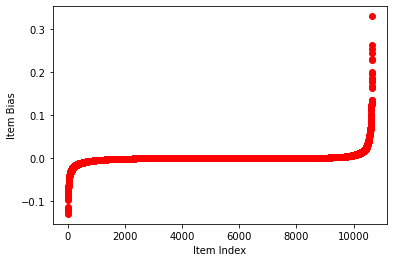

In [28]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating != 0])

pyplot.plot(item_mean_rating, 'ro')
pyplot.ylabel('Item Bias')
pyplot.xlabel('Item Index')
pyplot.show()

Now, we calculate the the average rating for each user, or "User Bias"

In [29]:
user_mean_rating = URM_train_unbiased.mean(axis=1)
user_mean_rating

matrix([[ 0.00000000e+00],
        [ 3.19770068e-04],
        [-7.19192581e-05],
        ...,
        [ 6.82456670e-04],
        [ 2.45208621e-04],
        [-2.31110739e-04]])

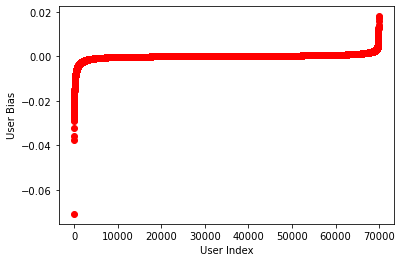

In [30]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

pyplot.plot(user_mean_rating, 'ro')
pyplot.ylabel('User Bias')
pyplot.xlabel('User Index')
pyplot.show()

Now we can sort the items by their item bias, and use the same recommendation principle as in `TopPop`

In [31]:
class GlobalEffectsRecommender(object):
    def fit(self, URM_train):
        self.URM_train = URM_train

        global_average = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= global_average

        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.best_rated_items = np.argsort(item_mean_rating)
        self.best_rated_items = np.flip(self.best_rated_items, axis = 0)
        
    def recommend(self, user_id, at=5, remove_seen=True):
        if not remove_seen:
            return self.best_rated_items[0:at]
        
        unseen_items_mask = np.in1d(self.best_rated_items, 
                                    URM_train[user_id].indices,
                                    assume_unique=True, 
                                    invert = True)
        unseen_items = self.best_rated_items[unseen_items_mask]

        return unseen_items[0:at]

In [32]:
global_effects_recommender = GlobalEffectsRecommender()
global_effects_recommender.fit(URM_train)

evaluate_algorithm(URM_test, global_effects_recommender)

Recommender performance is: Precision = 0.1685, Recall = 0.0391, MAP = 0.1223


## Now let's try to combine User bias an item bias

In [33]:
class GlobalEffectsRecommender(object):
    def fit(self, URM_train):
        self.URM_train = URM_train

        global_average = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= global_average
        
        # User Bias
        user_mean_rating = URM_train_unbiased.mean(axis=1)
        user_mean_rating = np.array(user_mean_rating).squeeze()
        
        # In order to apply the user bias we have to change the rating value 
        # in the URM_train_unbiased inner data structures
        # If we were to write:
        # URM_train_unbiased[user_id].data -= user_mean_rating[user_id]
        # we would change the value of a new matrix with no effect on the original data structure
        for user_id in range(len(user_mean_rating)):
            start_position = URM_train_unbiased.indptr[user_id]
            end_position = URM_train_unbiased.indptr[user_id+1]
            
            URM_train_unbiased.data[start_position:end_position] -= user_mean_rating[user_id]

        # Item Bias
        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.best_rated_items = np.argsort(item_mean_rating)
        self.best_rated_items = np.flip(self.best_rated_items, axis = 0)        
    
    def recommend(self, user_id, at=5, remove_seen=True):
        if not remove_seen:
            return self.best_rated_items[0:at]
        
        unseen_items_mask = np.in1d(self.best_rated_items, 
                                    URM_train[user_id].indices,
                                    assume_unique=True, 
                                    invert = True)
        unseen_items = self.best_rated_items[unseen_items_mask]

        return unseen_items[0:at]

In [34]:
global_effects_recommender = GlobalEffectsRecommender()
global_effects_recommender.fit(URM_train)

evaluate_algorithm(URM_test, global_effects_recommender)

Recommender performance is: Precision = 0.1685, Recall = 0.0391, MAP = 0.1223


The result is identical. User bias is essential in case of rating prediction but not relevant in case of TopK recommendations.

## Question:

Why is GlobalEffect performing worse than TopPop even if we are taking into account more information about the interaction?


.

.

.

The test data contains a lot of low rating interactions... We are testing against those as well, but GlobalEffects is penalizing interactions with low rating

In [35]:
URM_test.data[URM_test.data<=2]

array([2., 1., 1., ..., 2., 1., 2.])

## In reality 

We want to recommend items rated in a positive way, so let's build a new Test set with positive interactions only

In [36]:
URM_test_positive_only = URM_test.copy()

URM_test_positive_only.data[URM_test.data<=2] = 0
URM_test_positive_only.eliminate_zeros()
URM_test_positive_only

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 1721336 stored elements in Compressed Sparse Row format>

In [37]:
print("Deleted {} negative interactions".format(URM_test.nnz - URM_test_positive_only.nnz))

Deleted 277073 negative interactions


### Run the evaluation again for both

In [38]:
evaluate_algorithm(URM_test_positive_only, top_pop_recommender_remove_seen)

Recommender performance is: Precision = 0.1870, Recall = 0.0562, MAP = 0.1383


In [39]:
evaluate_algorithm(URM_test_positive_only, global_effects_recommender)

Recommender performance is: Precision = 0.1624, Recall = 0.0423, MAP = 0.1181


### GlobalEffects performs worse again...

Any ideas why?


.

.

.

Sometimes ratings are not really more informative than interactions, depends on their quality

### Take-home message: how you build your splitting and the task you are building the algorithm for are tightly interlinked

## Extra: Dataset management

With the following we define the dataset name and path and download the compressed file if necessary.

In [40]:
from typing import Tuple
from urllib.request import urlretrieve
import matplotlib.pyplot as pyplot
import os  

In [41]:
# Path will be ./data/Movielens_10M/
data_file_path = os.path.join(".", "data", "Movielens_10M") 

# File will be located at ./data/Movielens_10M/movielens_10m.zip
data_file_name = os.path.join(data_file_path, "movielens_10m.zip") 

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)
    
# If file does not exist exist, download
if not os.path.exists(data_file_name):
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

And now we should uncompress and extract the contents of the dataset.

In [42]:
with zipfile.ZipFile(data_file_name) as data_file:
    URM_path = data_file.extract("ml-10M100K/ratings.dat", path=data_file_path)
    
    with open(URM_path, 'r') as URM_file:
        print(type(URM_file))

<class '_io.TextIOWrapper'>


## Let's take a look at the data

In [43]:
print("user_id::item_id::rating::timestamp")
with open(URM_path, 'r') as URM_file:  
    for _ in range(10):
        print(URM_file.readline(), end="")

user_id::item_id::rating::timestamp
1::122::5::838985046
1::185::5::838983525
1::231::5::838983392
1::292::5::838983421
1::316::5::838983392
1::329::5::838983392
1::355::5::838984474
1::356::5::838983653
1::362::5::838984885
1::364::5::838983707


What should we do to count the number of interactions?

For this dataset, just count the number of rows (each row equals one interaction)

In [44]:
# Start from beginning of the file
num_interactions = 0
with open(URM_path, 'r') as URM_file:
    for _ in URM_file:
        num_interactions += 1

print ("The number of interactions is {}".format(num_interactions))

The number of interactions is 10000054


## Row Splitting


On the previous example, we totally ignored the items, users, ratings, and timestamps. Now we will create a function `row_split` that reads each row as a string and converts it as a tuple $(u, i, r, t)$, where $u$ is the user id, $i$ is the item id, $r$ is the rating that $u$ gave to $i$, and $t$ is the timestamp of this interaction.


In [45]:
def row_split(row_string: str) -> Tuple[int, int, float, int]:
    # Columns are separated by ::
    split = row_string.split("::")
    split[3] = split[3].replace("\n","")
    
    # Convert each column to its corresponding type 
    # (u -> int, i -> int, r -> float, t -> int)
    user_id = int(split[0])
    item_id = int(split[1])
    rating = float(split[2])
    timestamp = int(split[3])
    
    return user_id, item_id, rating, timestamp

Now that we created that function, we should be able to read the entire dataset.

In [46]:
URM_tuples = []

with open(URM_path, 'r') as URM_file:
    for line in URM_file:
        URM_tuples.append(row_split(line))

URM_tuples[0:10]

[(1, 122, 5.0, 838985046),
 (1, 185, 5.0, 838983525),
 (1, 231, 5.0, 838983392),
 (1, 292, 5.0, 838983421),
 (1, 316, 5.0, 838983392),
 (1, 329, 5.0, 838983392),
 (1, 355, 5.0, 838984474),
 (1, 356, 5.0, 838983653),
 (1, 362, 5.0, 838984885),
 (1, 364, 5.0, 838983707)]

## We can easily separate the four columns in different independent lists

In [47]:
user_list, item_list, rating_list, timestamp_list = zip(*URM_tuples)

user_list = list(user_list)
item_list = list(item_list)
rating_list = list(rating_list)
timestamp_list = list(timestamp_list)

In [48]:
user_list[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [49]:
item_list[0:10]

[122, 185, 231, 292, 316, 329, 355, 356, 362, 364]

In [50]:
rating_list[0:10]

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

In [51]:
timestamp_list[0:10]

[838985046,
 838983525,
 838983392,
 838983421,
 838983392,
 838983392,
 838984474,
 838983653,
 838984885,
 838983707]

In [52]:
data_export = os.path.join(data_file_path, "ml10m-processed.npz")
np.savez(data_export, 
         user_ids=user_list, 
         item_ids=item_list, 
         ratings=rating_list, 
         timestamps=timestamp_list)

## Now we can display some statistics

Specifically, we calculate the number of unique users and items, average number of interactions per user and items, and the sparsity, defined as $ 1 - \frac{\#interactions}{\#items \times \#users} $


In [53]:
user_list_unique = list(set(user_list))
item_list_unique = list(set(item_list))

num_users = len(user_list_unique)
num_items = len(item_list_unique)

avg_interactions_per_user = num_interactions / num_users
avg_interactions_per_item = num_interactions / num_items

sparsity = 1 - num_interactions / (num_items * num_users)

print("Number of items\t {}, Number of users\t {}".format(num_items, num_users))
print("Max ID items\t {}, Max Id users\t {}\n".format(max(item_list_unique), max(user_list_unique)))
print("Average interactions per user {:.2f}".format(avg_interactions_per_user))
print("Average interactions per item {:.2f}\n".format(avg_interactions_per_item))
print("Sparsity {:.2f} %".format(sparsity * 100))

Number of items	 10677, Number of users	 69878
Max ID items	 65133, Max Id users	 71567

Average interactions per user 143.11
Average interactions per item 936.60

Sparsity 98.66 %


## Item popularity

In [54]:
import numpy as np

item_popularity = (URM_all>0).sum(axis=0)
item_popularity

matrix([[    0, 26449, 12032, ...,     0,     0,     7]], dtype=int64)

In [55]:
item_popularity = np.array(item_popularity).squeeze()
item_popularity

array([    0, 26449, 12032, ...,     0,     0,     7], dtype=int64)

In [56]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    0,     0,     0, ..., 33668, 34457, 34864], dtype=int64)

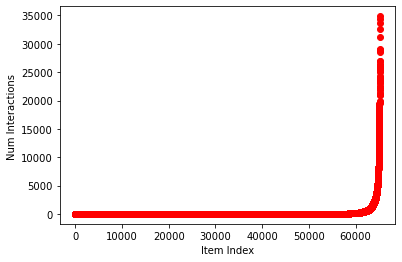

In [57]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index')
pyplot.show()

In [58]:
ten_percent = int(num_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(num_items*0.45):int(num_items*0.55)].mean()))

Average per-item interactions over the whole dataset 153.53
Average per-item interactions for the top 10% popular items 2390.00
Average per-item interactions for the least 10% popular items 0.00
Average per-item interactions for the median 10% popular items 0.00


In [59]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 54457


In [60]:
item_popularity_non_zero = item_popularity[item_popularity>0]

ten_percent = int(len(item_popularity_non_zero)/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity_non_zero.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity_non_zero[-ten_percent].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity_non_zero[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity_non_zero[int(num_items*0.45):int(num_items*0.55)].mean()))

Average per-item interactions over the whole dataset 936.60
Average per-item interactions for the top 10% popular items 2390.00
Average per-item interactions for the least 10% popular items 5.23
Average per-item interactions for the median 10% popular items 136.45


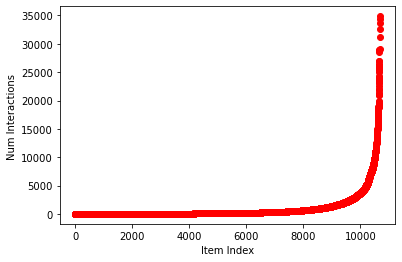

In [61]:
pyplot.plot(item_popularity_non_zero, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index')
pyplot.show()

## User activity

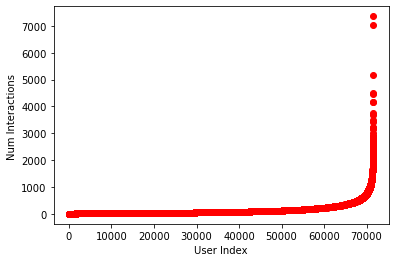

In [62]:
user_activity = (URM_all>0).sum(axis=1)
user_activity = np.array(user_activity).squeeze()
user_activity = np.sort(user_activity)

pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index')
pyplot.show()

## Rating distribution in time

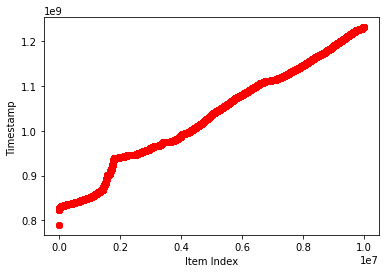

In [63]:
# sorted returns a new list, leaving timestamp_list intact
timestamp_sorted = sorted(timestamp_list)

pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Item Index')
pyplot.show()